#  <center> Taller  de Aprendizaje Automático </center>
##  <center> Taller 3: Demanda de bicicletas compartidas  </center>

#Introducción

En esta actividad se trabajará sobre el *dataset* de la competencia [*Bike Sharing Demand*](https://www.kaggle.com/c/bike-sharing-demand) de *Kaggle*. El objetivo de la competencia, predecir la demanda de bicicletas a partir de la combinación de datos históricos sobre demanda y clima. 

El conjunto corresponde a datos de alquiler por hora y abarcan dos años de información. El subconjunto de *train* está compuesto por los primeros 19 días de cada mes, mientras que el subconjunto de *test* va desde el día 20 hasta el final del mes. Este último debe ser utilizado solamente en la parte 10 para subir los resultados a la página de la competencia.

En esta actividad nos centraremos en el algoritmo **Decision Trees**, el cual al igual que *SVM* es un algoritmo versatil que se utiliza en problemas tanto de clasificación como de regresión. También trabajaremos con algoritmos basados en métodos de ensamble de estimadores, como son **Random Forest** y **Gradient Boosting**, que utilizan como estimador base **Decision Trees**.


## Objetivos


*   Conocer los estimadores *Decision Trees*, entender cómo funcionan para un problema de regresión, ver ventajas y desventajas.
*   Familiarizarse con los métodos de ensamblado de estimadores y entender cual es el objetivo de usar estos métodos.
*   Incorporar funciones personalizadas de transformación de columnas y medida de desempeño.


## Formas de trabajo

### Opción 1: Trabajar localmente

Descargar los datos en su máquina personal y trabajar en su propio ambiente de desarrollo. Asumiendo que ya creo un entorno para los talleres anteriores sólo debería installar la librería faltantes.  
 
*conda activate TAA-py38*    
*pip install xgboost seaborn*          
*jupyter-notebook*    

Los paquetes faltantes se pueden instalar desde el notebook haciendo:     
*!pip install paquete_faltante*

### Opción 2:  Trabajar en *Colab*. 

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TAA-fing/TAA-2021/blob/main/taller2_criticas_cine.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
</table>

Se puede trabajar en Google Colab. Para ello es necesario contar con una cuenta de **google drive** y ejecutar un notebook almacenado en dicha cuenta. De lo contrario, no se conservarán los cambios realizados en la sesión. En caso de ya contar con una cuenta, se puede abrir el notebook y luego ir a *Archivo-->Guardar una copia en drive*.

En caso de estar trabajando desde un notebook en Colab, deberá:

a) Installar el paquete *kaggle* para acceder a los datos 

In [ ]:
!pip install kaggle

b) realizar la configuración necesaria para obtener datos desde la plataforma Kaggle. Para ello deberá ir a la página de la competencia y en la sección *data* aceptar los términos. Luego ejecutar la siguiente celda y pasarle el *token* de su usuario (ver comentario en celda).

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


Una vez guardado el *token* se pueden descargar los datos.

In [ ]:
# Descarga de datos
!kaggle competitions download -c bike-sharing-demand

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_submission = pd.read_csv('sampleSubmission.csv')

test.csv: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


# Datos



### Parte 1 - Analisis de los datos
Analizar el conjunto de datos con las diferentes funciones de *pandas* que crea pertinente.

### Parte 2 - Características temporales

La primer columna de los datos (*datetime*) corresponde a las marcas de tiempo asociadas a cada instancia. Para que estos tengan el orden cronológico que representan es necesario pasarlos de tipo *string* a tipo *datetime*. Para esto *Pandas* proporciona la función *to_datetime()*. Correr la siguiente celda para hacer el cambio.


In [ ]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

El tipo de dato *datetime* permite extraer de forma sencilla datos categóricos como la hora, el día de la semana, entre otros. La siguiente celda agrega a los datos de *train* estas nuevas características.

In [ ]:
df_train['hour'] = df_train['datetime'].dt.hour
df_train['weekday'] = df_train['datetime'].dt.weekday

La figura siguiente muestra cómo varía la cantidad de bicicletas alquiladas en función del tiempo. 

*   Entre el día, el mes y el año ¿cuáles de estos datos les pareces agregar como nuevas características y cuáles no? y ¿Por qué?
*   Agregar las características seleccionadas.



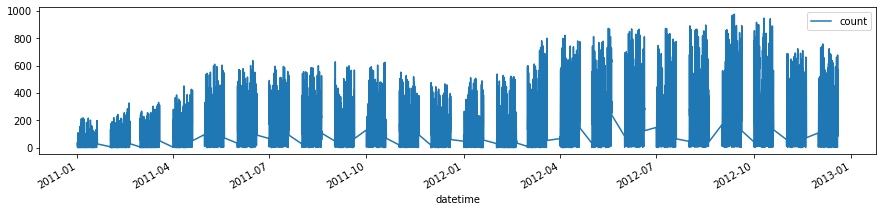

In [ ]:
df_train.plot(x='datetime', y='count', figsize=[15,3]) 
plt.show()



*   Utilizar operadores condionales y graficar la cantidad de alquileres para diferentes intervalos de tiempo. Ejemplo:
```
df_train['datetime'] < pd.to_datetime('2011-02-01')
```
*   Discutir que patrones se logran observar.



# Estimadores

Previo a trabajar con los estimadores:

*   Apartar la columna objetivo y eliminarla del conjunto de entrenamiento. 
*   Eliminar las columnas *'casual'* y *'registered'*. ¿Por qué esto es necesario?.
*   Eliminar la columna *'datetime'*.

Durante la actividad los estimadores deben ser evaluados con la misma medida de desempeño utilizada en la competencia: 

Root Mean Squared Logarithmic Error (RMSLE)
$$\sqrt{\frac{1}{n}\sum_{i}^{n}\big(\log(y_{i} + 1) - \log(\hat{y}_{i} + 1)\big)^2}$$

Este tipo de medida se utiliza cuando los valores a estimar son grandes. La librería *Scikit-Learn* incluye la función de desempeño [*mean_squared_log_error*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE), esta función se puede utilizar  para la validación ya que alcanza las mismas soluciones que su raíz (RMSLE). De igual forma los resultados se deben mostrar con RMSLE. 

## Decision Trees
 

### Parte 3 - Hiperparámetros de regularización

*   Importar la función *DecisionTreeRegressor()* de *Scikit-Learn*. 
*   Aplicar validación cruzada a un estimador con los hiperparámetros por defecto.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Para lo último utilizar la función *fill_between()* de *matplotlib*. 



*   ¿Qué fenómeno se logra apreciar en el gráfico? ¿A qué se debe? ¿Por qué esto es un problema?
*   Indicar y describir alguno de los hiperparámetros que la función *DecisionTreeRegressor()* ofrece para limitar la complejidad del estimador.



### Parte 4 - Ajuste fino


*   Seleccionar uno de los hiperparámetros y encontrar el mejor estimador.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los resultados anteriores.
*   Graficar cómo varían los valores de RMSLE de entrenamiento y validación, para diferentes valores del hiper-parámetro.
*   Mostrar el mejor valor RMSLE (promedio de todos los *folds*) y el valor del hiper-parámetro.
*   Visualizar el árbol hasta los nodos de profundidad 2 utilizando la función *plot_tree()*. Agrandar el tamaño de la imagen de manera de poder leer la descripción de cada nodo.
*   Analizar las decisiones que está tomando el árbol para los primeros nodos.
*   Graficar los primeros 200 valores objetivo junto con sus predicciones.




## Random Forest


### Parte 5 - Ensamble
*   ¿Cuáles son las ventajes de los métodos de Ensamble?.
*   ¿A qué métodos de ensamble está asociado *Random Forest*?.
*   Importar la función *RandomForestRegressor()* de *Scikit-Learn*.
*   Indicar y describir los principales hiperparámetros correspondientes a los métodos de ensamble que ofrece la función.




### Parte 6 - Ajuste fino



*   Encontrar el mejor estimador para *Random Forest* usando como estimador base el encontrado en la parte 4.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los resultados correspondientes de la parte 4.
*   Mostrar el mejor valor de RMSLE (promedio de todos los folds) y compararlo con el de la parte 4. Mostrar los valores seleccionados de los hiperparámetros.
*   ¿Qué ventaja se pierde con repecto a usar un sólo árbol?
*   Graficar los primeros 200 valores objetivo junto con sus predicciones. Comparar con el gráfico correspondiente de la parte 4.
*   Mostrar la importancia de cada característica utilizando la variable *feature_importances_*.



## Gradient Boosting





 


### Parte 7 - XGBoost

*   Indicar cuál es la principal diferencia entre *Bagging* y *Boosting*.
*   Importar la función *XGBRegressor()* de la librería [*xgboost*](https://github.com/dmlc/xgboost).
*   Este estimador a diferencia de los anteriores puede devolver predicciones negativas para estos datos. Indicar en que caso se pueda dar esto y por qué esto no sucedía con los estimadores anteriores.
*   Las predicciones negativas no pueden ser evaluadas por RMSLE. Por lo tanto, crear una nueva función de evaluación que fuerce a cero todos los valores negativos de las predicciones y luego calcule el valor de RMSLE. Para esto se debe utilizar la función *make_score* de *Sickit-Learn*, para que la nueva función pueda ser utilizada en las funciones de selección de modelos.


**Nota:** *Scikit-Learn* también ofrece una implementación de *Gradient Boosting*, pero *XGBRegressor()* es la implementación de [*eXtreme Gradient Boosting*](https://arxiv.org/pdf/1603.02754.pdf?__hstc=133736337.1bb630f9cde2cb5f07430159d50a3c91.1513641600097.1513641600098.1513641600099.1&__hssc=133736337.1.1513641600100&__hsfp=528229161) un variante del algoritmo tradicional que dentro de algunas ventajas requiere menos tiempo de entrenamiento. La implementación de las funciones de la libreía son muy similares a las de *Scikit-Learn*, de igual forma aquí le dejamos un [ejemplo](https://www.kaggle.com/alexisbcook/xgboost) de cómo usarla. 







### Parte 8 - Ajuste fino



*   Encontrar el mejor estimador para *Gradient Boosting* usando como estimador base el encontrado en la parte 4.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los gráficos correspondientes.
*   Mostrar el mejor valor de RMSLE (promedio de todos los folds) y compararlo con los anteriores. Mostrar los valores seleccionados de los hiperparámetros.
*   Graficar los primeros 200 valores objetivo junto con sus predicciones. Comparar con los gráficos corespondientes.
*   ¿Qué compromiso hay entre los hiperparámetros *n_estimators* y *learning_rate*?



# Pipeline

## Parte 9 - Custom Transformers 

Construir un *Custom Transformer* que sustituya la columna *'datetime'* por las caracterísicas temporales, siguiendo el ejemplo del capítulo 2 del libro.

## Parte 10 - Submit
Construir un *pipeline* para el estimador que consideren que tuvo mejor desempeño. El pre-procesamiento debe incluir la extracción de las nuevas características.

Subir los resultados del *pipeline* para los datos de *test*,  a la [página](https://www.kaggle.com/c/bike-sharing-demand/submit) de la competencia.



*   ¿Cuánto fue el valor de RMSLE para el conjunto de test?
